In [60]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from datetime import datetime
# Importing the keras library and the TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
# Importing the necessary libraries to create/construct the deep neural network model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense ,Dropout,BatchNormalization
from tensorflow.keras import initializers
import tensorflow as tf
import time
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
from google.colab import files
uploaded= files.upload()

Saving Water_dataX_mean_state_hong_kong.csv to Water_dataX_mean_state_hong_kong.csv


In [61]:
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [67]:
# Load the data into a pandas DataFrame called df
def choice_of_zone_river_station (df) : 
  df=df[['water control zone','river','station','dates','wqi']]

  B = set(df['water control zone'])
  print('choisir votre zone parmi : ')    
  print(B)
  zone=input()

  C = set(df[df['water control zone']==zone]['river'])
  print('choisir votre rivier parmi ')
  print(C)
  river=input()

  D=set(df[df['river']==river]['station'])
  print('choisis votre station parmi :')
  print(D)
  station=input()

  data = df[['dates', 'wqi']][(df['water control zone'] ==zone) & (df['river'] == river) & (df['station'] == station)]
  data.to_csv('data1.csv', index=False)
  
  # Load the data into a pandas DataFrame called df
  df_selected = pd.read_csv('data1.csv')
  zone_river_station = {"Selected zone = ": zone, "Selected river = ": river, "Selected station = ": station}

  return df_selected, zone_river_station
# Column renaming
def preprocessing(dataset,zone_river_station):
    dataset.rename(columns={'wqi':'water_quality_index'},inplace=True)
    dataset.rename(columns={'dates':'DATE'},inplace=True)
    # 'DATE' column is converted from 'object' data type to 'datetime' 
    dataset['DATE'] = pd.to_datetime(dataset['DATE'])
    dataset['DATE'] = dataset['DATE'].apply(lambda x: x.replace(day=1))
    # Feature Engineering is applied to extract the Months and Years from the 'DATE' column
    dataset['Year'] = dataset['DATE'].apply(lambda date:date.year)
    dataset['Month'] = dataset['DATE'].apply(lambda date:date.month)
    # 'DATE' column is set as dataset index
    dataset=dataset.set_index(['DATE'])
    # Mapping to rename the entries of the 'Month' column
    num_to_name={1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',
                                      6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}
    dataset['Month'] = dataset['Month'].map(num_to_name)
    # Boxplots of Water quality index grouped by Month and Year. Based on the 'Months' boxplot, it can be observed that
    fig,axs=plt.subplots(2,1,figsize=(12,6))
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams['font.size']=13
    sns.boxplot(x='Month',data=dataset,y='water_quality_index',palette='viridis',ax=axs[0])
    axs[0].set_ylabel('Water Quality Index',fontweight='bold')
    axs[0].set_title('Water Quality Index grouped by Month',fontweight='bold')
    sns.boxplot(ax=axs[1],x='Year',data=dataset,y='water_quality_index',palette='viridis')
    axs[1].set_xlabel('Year',fontweight='bold')
    axs[1].set_ylabel('Water Quality Index',fontweight='bold')
    axs[1].set_title('Water Quality Index grouped by Year',fontweight='bold')
    plt.setp(axs[1].get_xticklabels(), rotation=30)
    for ax in axs.flat:
        ax.figure.tight_layout(pad=2)
    # Dropping the 'Year', 'Month' columns
    data=dataset.drop(['Year','Month'],axis=1)
    # Time Series Plot
    data.plot(figsize=(14,6))
    plt.xlabel('DATE',fontweight='bold')
    plt.ylabel('Monthly Water Quality Index',fontweight='bold');
    plt.title('Water Quality Index Time Series',fontweight='bold')
    return data
def Split_into_train_test(data,coef) : 
  # Test size: 48 months
  test_size = int(len(data) * coef)
  # Dataset is split into training and test data
  train = data.iloc[:len(data)- test_size]
  test = data.iloc[-test_size:]
  # Scaling the training and test data
  scaler = MinMaxScaler()
  scaler.fit(data)
  scaled_train = scaler.transform(data)
  scaled_test = scaler.transform(test)
  return train, test, scaled_test, scaled_train,test_size

# Define a function to create sequences of data 
def create_sequences(scaled_train,scaled_test,test_size):
  # Training Batch length
  length = test_size-1
  # No. of features
  n_features=1
  # Creating the time series generator
  time_series_generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)
  # First batch of the time_series_generator- training and test values
  InpSeq,TargetVal=time_series_generator[0]
  # At the first batch, the generator takes the first 29 samples to predict the next sample
  # Use of random seed to get the same results at every run
  tf.random.set_seed(0)
  np.random.seed(0)
  # Use of the he_uniform initializer to set the initial random weights of the model layers. 
  initializer = tf.keras.initializers.he_uniform(seed=0)
  time_series_val_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=1)
  return time_series_generator,time_series_val_generator,length,initializer
# Determining all CNN outputs

# Define the CNN model
def CNN_model(length,initializer) :
  # Initially, the network model is defined 
  model = Sequential()
  model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(length,1),kernel_initializer=initializer))
  model.add(MaxPooling1D(pool_size=2))
  model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Conv1D(filters=256, kernel_size=2, activation='relu'))
  model.add(MaxPooling1D(pool_size=1))
  model.add(Flatten())
  model.add(Dense(units=256, activation='relu'))
  # The output layer consists of 1 neuron with a 'linear' activation fuction 
  model.add(Dense(1,activation='linear',kernel_initializer=initializer))
  # The model is compiled using MSE as  loss function and Adam as optimizer
  return model
# Define the LSTM model
def LSTM_model(length,initializer) :
  model = Sequential()
  model.add(LSTM(150, activation='relu', input_shape=(length,1),kernel_initializer=initializer))
  # The output layer consists of 1 neuron with a 'linear' activation fuction 
  model.add(Dense(1,activation='linear',kernel_initializer=initializer))
  return model

def ARIMA_model(time_series_generator) :
  # Create an ARIMA model with order (1, 3, 2)
  model = sm.tsa.arima.ARIMA(time_series_generator['water_quality_index'], order=(11,1,11))
  #model = sm.tsa.arima.ARIMA(data_selected['wqi'], order=(1, 1, 2))
  
  return model
def run_model (choix_model,time_series_generator,time_series_val_generator, epochs) : 
  # Train the model
  # Début du chrono
  start_time = time.time()
  # Enregistrer les temps de départ
  # Train the model
  if (str(choix_model)== 'ARIMA') :     
    model = ARIMA_model(time_series_generator)
    model = model.fit()
    # save model
    model.save('model.pkl')
    history = model # a modifier
  elif (choix_model== 'CNN') :
    model = CNN_model(length,initializer)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    history=model.fit_generator(time_series_generator,epochs=epochs,shuffle=False,validation_data=time_series_val_generator) 
    model.save('forcasting_hong_kong_'+str(choix_model)+'.h5')
  elif (choix_model== 'LSTM') :
    model = LSTM_model(length,initializer)
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=opt, loss='mse')
    history=model.fit_generator(time_series_generator,epochs=epochs,shuffle=False,validation_data=time_series_val_generator) 
    model.save('forcasting_hong_kong_'+str(choix_model)+'.h5')
  else : 
    print("choix erroné !! ")   
  # Fin du chrono
  end_time = time.time()
  # Calcul de la durée d'entraînement en secondes
  training_time = end_time - start_time

  return model, history, training_time

def run_models (data,length,scaled_train,scaled_test,time_series_generator,time_series_val_generator,epochs) :
  CPU_time = dict()
  histories = dict()
  train_predictions = dict()
  outputs_forcast = dict()
  mse = dict()

  models = {'CNN', 'ARIMA', 'LSTM'}
  for choice in models :
    
    if (choice == 'CNN') :
      print ('************** '+ str(choice) + ' model is running ********* : ')
      model, history, training_time = run_model (choice,time_series_generator,time_series_val_generator, epochs) 
      test[str(choice)+' Predictions'],train_prediction,actual_train,outputs_forcast[choice]=predict_training_test_set_and_forcasting(model,data,scaled_train,scaled_test,length,choice)
      train_predictions[choice] = train_prediction
      # la durée d'entraînement
      mse[choice] = mean_squared_error(actual_train,train_predictions[choice])
      CPU_time [choice] = training_time
      histories[choice] = history 
    elif (choice == 'LSTM') :
      print ('************** '+ str(choice) + ' model is running ********* : ')
      model, history, training_time = run_model (choice,time_series_generator,time_series_val_generator, epochs)
      test[str(choice)+' Predictions'],train_prediction,actual_train,outputs_forcast[choice]=predict_training_test_set_and_forcasting(model,data,scaled_train,scaled_test,length,choice)
      train_predictions[choice] = train_prediction
      #la durée d'entraînement
      CPU_time [choice] = training_time
      #Calculate the MSE
      mse[choice] = mean_squared_error(actual_train,train_predictions[choice])
      histories[choice] = history
    if (choice == 'ARIMA') :
      print ('************** '+ str(choice) + ' model is running ********* : ')
      df = data.reset_index()
      train_size = int(len(data))
      train = df[:train_size]
      model, history, training_time = run_model (choice,train,time_series_val_generator, epochs) 
      train_prediction,actual_train,outputs_forcast[choice]=predict_training_test_set_and_forcasting_with_arima(model,train,length,choice)
      train_predictions[choice] = train_prediction
      #la durée d'entraînement
      CPU_time [choice] = training_time
      histories[choice] = history
    else : 
      print("choix erroné !! ")

  return test,train_predictions,actual_train,outputs_forcast,CPU_time, histories,mse

In [74]:
# A new scaler is being initialized
def tracer_graph_for_forcasting_with_cnn(length,cnn_outputs,choix_model):
  # Creating an index for the CNN forecasts
  cnn_forecast_index=pd.date_range(start='2021-01-01',periods=length,freq='M')
  # Converting the cnn_outputs from np.ndarray to pandas dataframe
  cnn_forecast_df=pd.DataFrame(data=cnn_outputs,index=cnn_forecast_index,columns=[str(choix_model)+' Forecasts'])
  # Plot comprising the original time series,and the 48-month CNN forecasts
  ax=data.plot(figsize=(12,4),marker='o',linestyle='-',markersize=3)
  cnn_forecast_df.plot(ax=ax,marker='o',linestyle='--',markersize=3)
  plt.title(str(choix_model)+' '+' 8 -years Ahead Forecast',fontweight='bold')
  plt.ylabel('Monthly water quality index',fontweight='bold')
  plt.xlabel(' DATE',fontweight='bold')

def predict_training_test_set_and_forcasting_with_arima(model,data,lenght,choix_model):
    df = data.reset_index()
    train_size = int(len(data))
    train = df[:train_size]
    size=int(len(data)*0.75)
    train_data, test_arima = df[:size], df[size:]
    start_index = len(train_data)
    end_index = len(train_data) + len(test_arima) - 1
    train_predictions = model.predict(start=train.index[0], end=train.index[-1])
    start_date = pd.to_datetime('2021-01-01')
    end_date = pd.to_datetime('2028-12-09')
    forecast_index = pd.date_range(start=start_date, end=end_date, freq='MS')
    cnn_outputs = model.forecast(steps=len(forecast_index))
    cnn_outputs.index = forecast_index
    actual_train = train
    return train_predictions,actual_train,cnn_outputs
    
def predict_training_test_set_and_forcasting(model,data,scaled_train,scaled_test,lenght,choix_model):
  training_outputs = []
  batch = scaled_train[:length].reshape((1, length,1))
  for i in range(len(scaled_train[length:])):
      train_out = model.predict(batch)[0]
      training_outputs.append(train_out) 
      batch = np.append(batch[:,1:,:],[[scaled_train[length:][i]]],axis=1)

  #Inverse transforming the expected values
  # Création de l'instance du scaler
  scaler = MinMaxScaler()
  scaler.fit_transform(data)
  actual_train=scaled_train[length:]
  actual_train=scaler.inverse_transform(actual_train)
  # Inverse transforming the CNN predictions on the training set
  train_predictions=scaler.inverse_transform(training_outputs)
  #'CNN Performance on the training set - Actual vs. Predicted Values'
  test_outputs = []
  batch = scaled_test[-length:].reshape((1, length,1))

  for i in range(len(test)):
      test_out = model.predict(batch)[0]
      test_outputs.append(test_out) 
      batch = np.append(batch[:,1:,:],[[test_out]],axis=1)

  # Inverse transforming the CNN predicitons
  cnn_predictions = scaler.inverse_transform(test_outputs)
  # A new test feature is created to comprise the CNN test predictions
  test[str(choix_model)+' Predictions'] = cnn_predictions.round(2)

  data_scaler=MinMaxScaler()
  # fit_transform function applied to all dataset's entries
  scaled_set=data_scaler.fit_transform(data)
  # A new TimeseriesGenerator is created to include the new scaled values, (batch_size = 1 , length=12)
  data_generator=TimeseriesGenerator(scaled_set,scaled_set,length=length,batch_size=1)
  train_index=data.index[:-length]
  # Converting the LSTM predictions from np.ndarray to pandas dataframe
  f_train_df=pd.DataFrame(data=train_predictions,index=train_index,columns=['Predicted_Train'])
  cnn_outputs=[]
  batch = scaled_set[-length:].reshape((1, length,1))

  for i in range(length):
      cnn_out = model.predict(batch)[0]
      cnn_outputs.append(cnn_out) 
      batch = np.append(batch[:,1:,:],[[cnn_out]],axis=1)
  # Inverse transforming the CNN forecasts
  cnn_outputs=data_scaler.inverse_transform(cnn_outputs)
  return test[str(choix_model)+' Predictions'],train_predictions,actual_train,cnn_outputs

def tracer_graphe(test,train_predictions,actual_train,choix_model):
  # Plot of the Test vs. Predicted values for a prediction horizon of 48 months 
  fig, axs = plt.subplots(2, 1, figsize=(12, 6))
  plt.rcParams["font.weight"] = "bold"
  plt.rcParams['font.size'] = 13

  # Plotting the training set
  axs[0].plot(actual_train, marker='o', linestyle='-', label='Target_Train_Values')
  axs[0].plot(train_predictions, marker='o', linestyle='dashed', label='Predicted_Train_Values')

  # Plotting the test set
  axs[1].plot(test['water_quality_index'], marker='o', linestyle='-', label='Target_Test_Values')
  axs[1].plot(test[str(choix_model)+' Predictions'], marker='o', linestyle='dashed', label='Predicted_Test_Values')

  # Adding titles and labels to the plots
  axs[0].set_title(str(choix_model)+' Performance on the Training Set - Actual vs. Predicted Train Values', fontweight='bold')
  axs[0].set_xlabel('Time Steps', fontweight='bold')
  axs[0].set_ylabel('Monthly water quality index', fontweight='bold')
  axs[0].legend()

  axs[1].set_title(str(choix_model)+' Test Set Performance - Expected vs. Predicted Values',fontweight='bold')
  axs[1].set_xlabel('DATE', fontweight='bold')
  axs[1].set_ylabel('Monthly Water Quality Index', fontweight='bold')
  axs[1].legend()

  fig.tight_layout(pad=1)
def tracer_graph_for_predict_all_dataset_with_cnn(data,length,test,train_predictions,choix_model):
  # Creating an index for the LSTM predictions on the Training Set
  if(choix_model=='ARIMA'):
    train_index=data.index
    train_df = pd.DataFrame(data=train_predictions, index=train_index, columns=['Train_Set Predictions'])
    # Tracer le graphique en utilisant les données d'origine, les prévisions du modèle sur l'ensemble d'entraînement et les prévisions du modèle sur l'ensemble de test
    ax = data.plot(figsize=(12,4), marker='o', linestyle='-')
    train_df.plot(ax=ax, marker='o', linestyle='--', legend=True)
    # Personnaliser le graphique
    plt.title(str(choix_model)+' Predictions on the Training & Test Set', fontweight='bold')
    plt.ylabel('water_quality_index', fontweight='bold')
    plt.xlabel('DATE', fontweight='bold')
    plt.show()
  else:
    train_index=data.index[:-length]
    # Convertir le tableau train_predictions en DataFrame Pandas
    train_df = pd.DataFrame(data=train_predictions, index=train_index, columns=['Train_Set Predictions'])
    # Tracer le graphique en utilisant les données d'origine, les prévisions du modèle sur l'ensemble d'entraînement et les prévisions du modèle sur l'ensemble de test
    ax = data.plot(figsize=(12,4), marker='o', linestyle='-')
    train_df.plot(ax=ax, marker='o', linestyle='--', legend=True)
    test[str(choix_model)+' Predictions'].plot(ax=ax, legend=True, marker='o', linestyle='dashed')

    # Personnaliser le graphique
    plt.title(str(choix_model)+' Predictions on the Training & Test Set', fontweight='bold')
    plt.ylabel('water_quality_index', fontweight='bold')
    plt.xlabel('DATE', fontweight='bold')
    plt.show()

# Affichage de la durée d'entraînement
def tracer_graph_for_error(choix_model,training_time,historie):
  # Training and validation loss plot
  fig, ax = plt.subplots(figsize=(12,4))
  plt.rcParams["font.weight"] = "bold"
  plt.rcParams['font.size'] = 8
  train_loss = pd.DataFrame(historie[choix_model].history)
  train_loss['epochs'] = range(1, len(train_loss) + 1)

  ax.plot(train_loss['epochs'], train_loss['loss'], label='Training Loss')
  ax.plot(train_loss['epochs'], train_loss['val_loss'], label='Validation Loss')
  ax.set_title('CNN Training and Validation Loss', fontweight='bold')
  ax.set_xlabel('Epochs', fontweight='bold')
  ax.set_ylabel("Loss-'MSE'", fontweight='bold')
  ax.legend(loc='upper right', fontsize=8)

  plt.show()

  # Training and validation loss plots
  fig,axs=plt.subplots(1,2,figsize=(12,4))
  plt.rcParams["font.weight"] = "bold"
  plt.rcParams['font.size']=8
  train_loss = pd.DataFrame(historie[choix_model].history)
  train_loss.loss.plot(ax=axs[0])
  axs[0].set_title(str(choix_model)+' Training Loss',fontweight='bold')
  train_loss.val_loss.plot(ax=axs[1],color='coral')
  axs[1].set_title(str(choix_model)+' Validation Loss',fontweight='bold')
  for ax in axs.flat:
      ax.set_xlabel('Epochs',fontweight='bold')
      ax.set_ylabel("Loss-'MSE'",fontweight='bold')

   
      ax.figure.tight_layout(pad=2)


def tracer_graph_for_error_for_arima(historie):
  fig, ax = plt.subplots(figsize=(8,3))
  plt.rcParams["font.weight"] = "bold"
  plt.rcParams['font.size'] = 8
  train_loss = pd.DataFrame(histories['ARIMA'].resid)
  ax.plot(train_loss,label='Residual')
  ax.set_title('Loss of arima', fontweight='bold')
  ax.set_xlabel('Samples', fontweight='bold')
  ax.set_ylabel("Loss", fontweight='bold')
  ax.legend(loc='upper right', fontsize=8)
  plt.show()


choisir votre zone parmi : 
{'Deep Bay', 'Tolo Harbour And Channel', 'Victoria Harbour', 'DB4', 'North Western', 'Junk Bay', 'Southern', 'Port Shelter', 'DB7', 'Western Buffer'}
Junk Bay
choisir votre rivier parmi 
{'Tseng Lan Shue Stream'}
Tseng Lan Shue Stream
choisis votre station parmi :
{'JR11', 'JR6', 'JR3'}
JR11


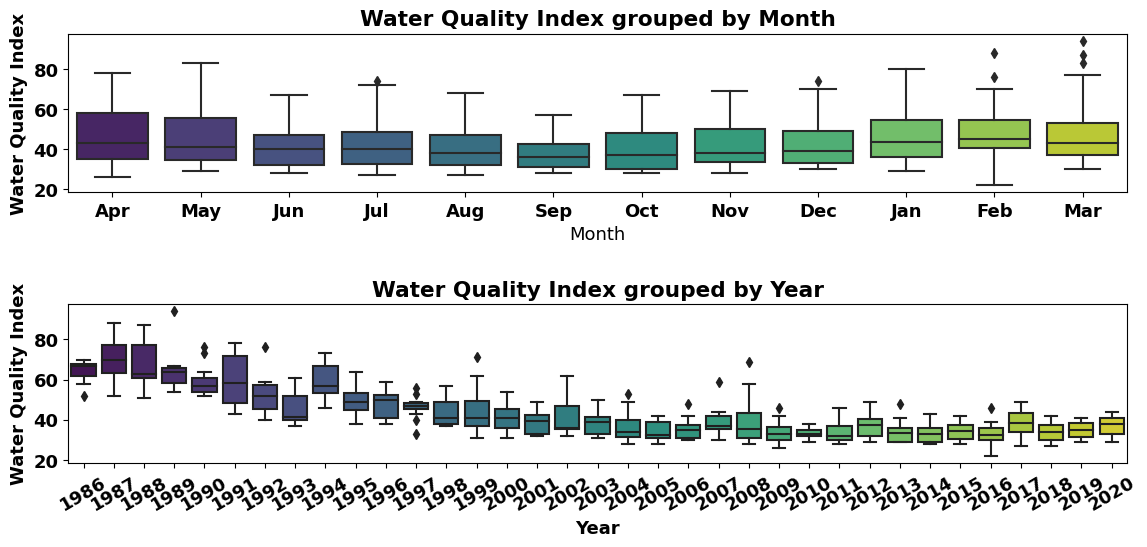

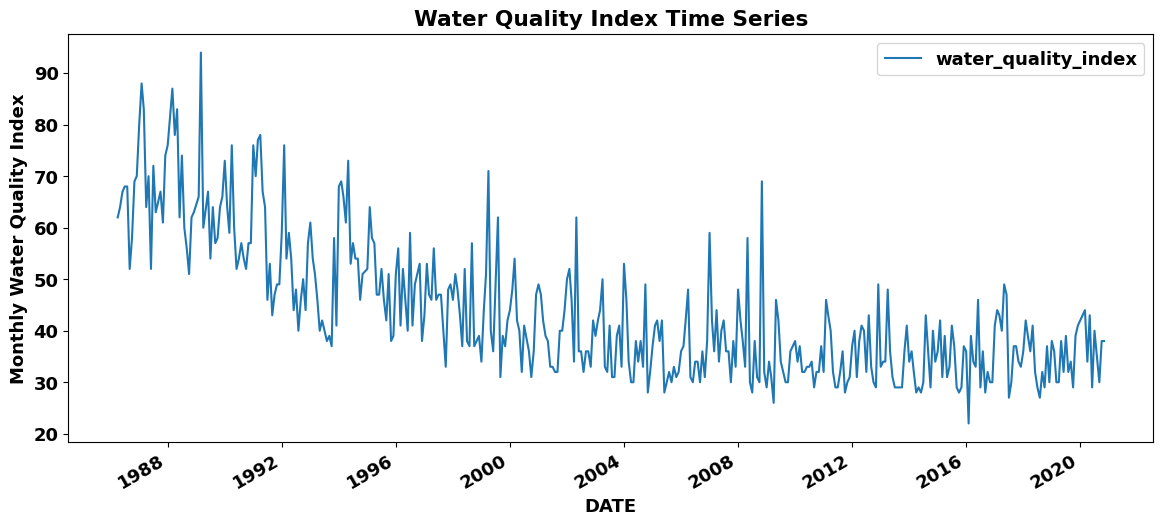

In [68]:
# Load the data into a pandas DataFrame called df
df=pd.read_csv('Water_dataX_mean_state_hong_kong.csv')
data_selected, zone_river_station = choice_of_zone_river_station(df)
data=preprocessing(data_selected,zone_river_station)
train, test, scaled_test, scaled_train,test_size=Split_into_train_test(data,0.25)
time_series_generator,time_series_val_generator,length,initializer=create_sequences(scaled_train,scaled_test,test_size)

In [70]:
test,train_predictions,actual_train,outputs_forcast,CPU_time, histories,mse=run_models (data,length,scaled_train,scaled_test,time_series_generator,time_series_val_generator,50) 

************** ARIMA model is running ********* : 
************** LSTM model is running ********* : 
Epoch 1/50
307/307 [==============================] - 17s 50ms/step - loss: 0.0343 - val_loss: 4.1545e-06
Epoch 2/50
307/307 [==============================] - 15s 50ms/step - loss: 0.2125 - val_loss: 0.0021
Epoch 3/50
307/307 [==============================] - 15s 50ms/step - loss: 0.0121 - val_loss: 0.0023
Epoch 4/50
307/307 [==============================] - 16s 52ms/step - loss: 0.0110 - val_loss: 0.0023
Epoch 5/50
307/307 [==============================] - 16s 52ms/step - loss: 0.0107 - val_loss: 0.0023
Epoch 6/50
307/307 [==============================] - 15s 49ms/step - loss: 0.0105 - val_loss: 0.0024
Epoch 7/50
307/307 [==============================] - 15s 50ms/step - loss: 0.0104 - val_loss: 0.0025
Epoch 8/50
307/307 [==============================] - 15s 49ms/step - loss: 0.0103 - val_loss: 0.0024
Epoch 9/50
307/307 [==============================] - 16s 51ms/step - loss: 0.0

########################################## Test on the selected data ########################################### :
{'Selected zone = ': 'Junk Bay', 'Selected river = ': 'Tseng Lan Shue Stream', 'Selected station = ': 'JR11'}
**************************************************TIME OF TRAINING*********************************************************************
CPU time of ARIMA model :  5.639468193054199 secondes
CPU time of LSTM model :  896.4719679355621 secondes
CPU time of CNN model :  894.2158913612366 secondes
**************************************************ERREUR*******************************************************************************
Mean Square Erreur of ARIMA model: 60.38212598223748
Mean Square Erreur of LSTM model: 52.99267296087342
Mean Square Erreur of CNN model: 5.854950935459537


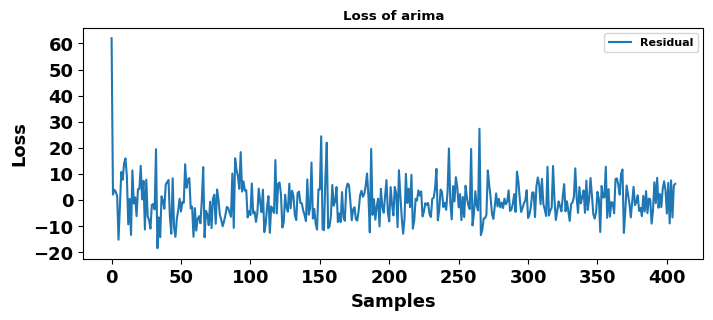

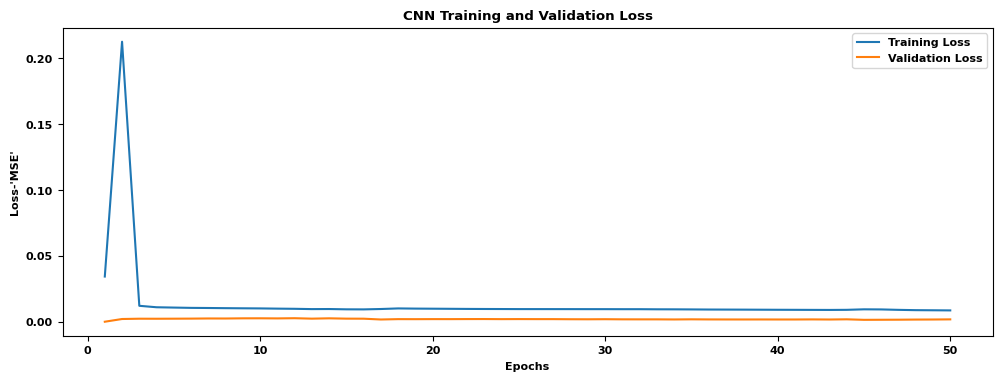

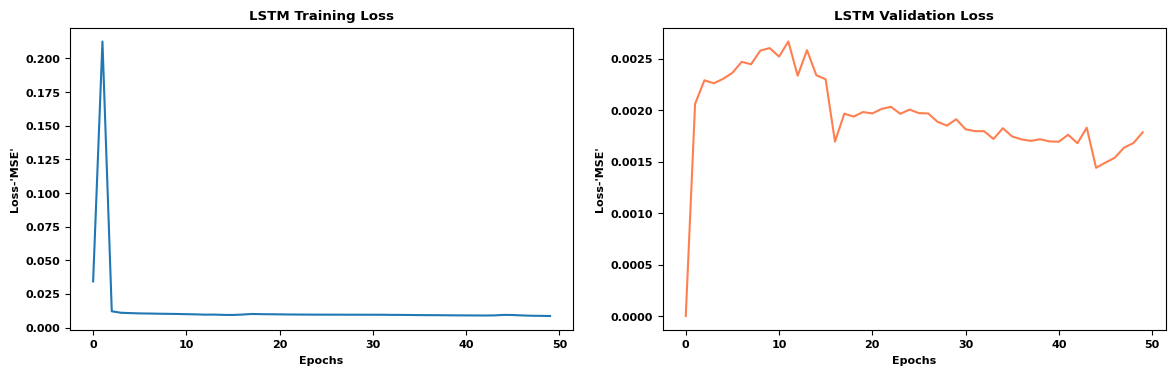

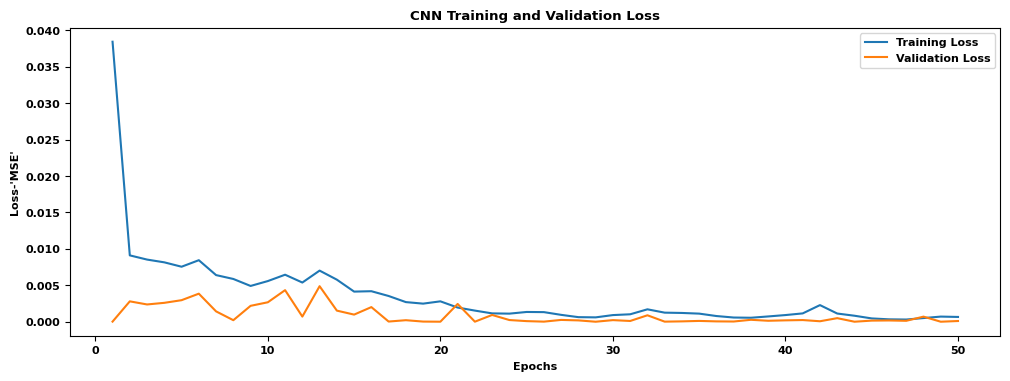

************************************************************************************************************************************


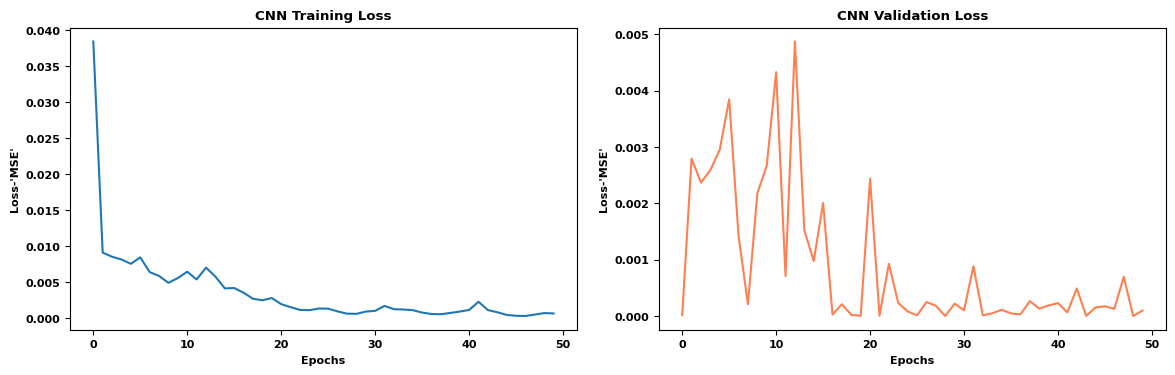

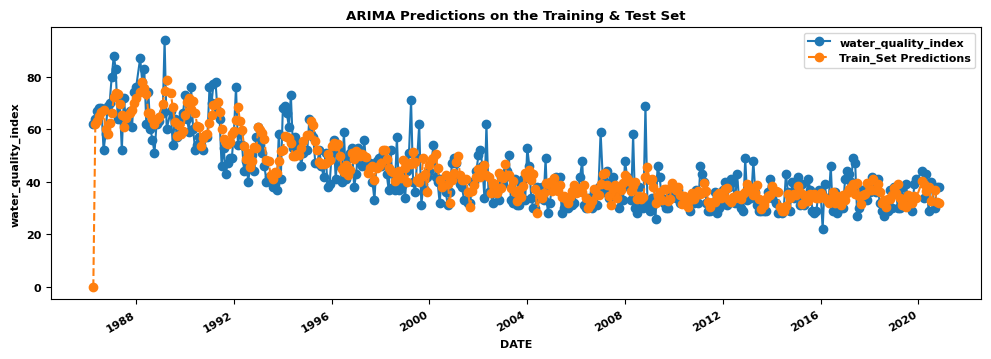

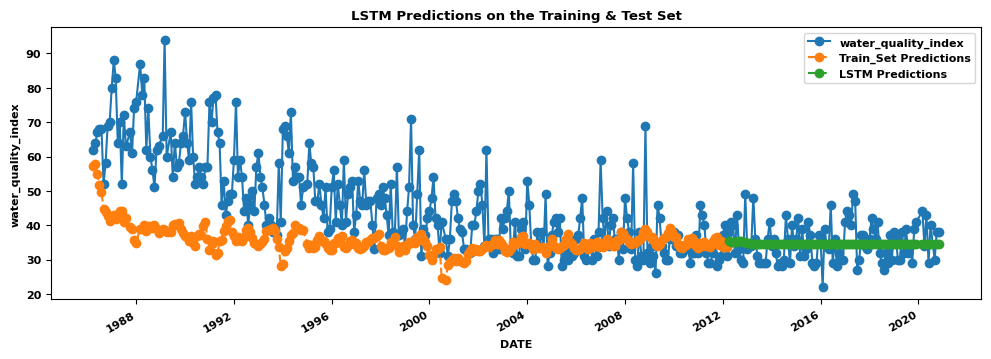

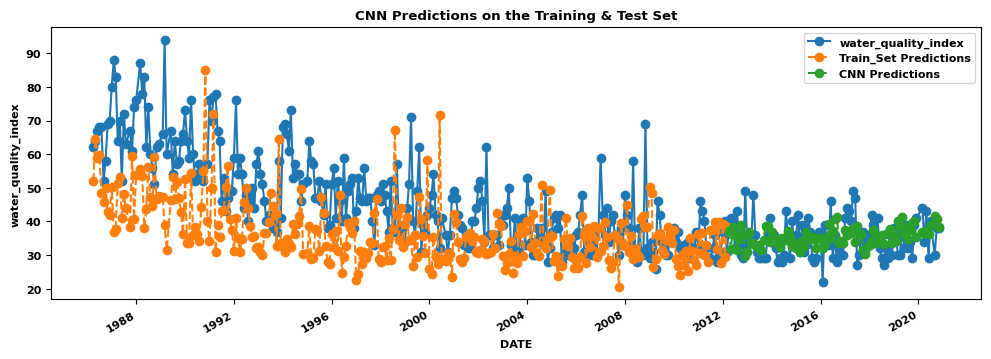

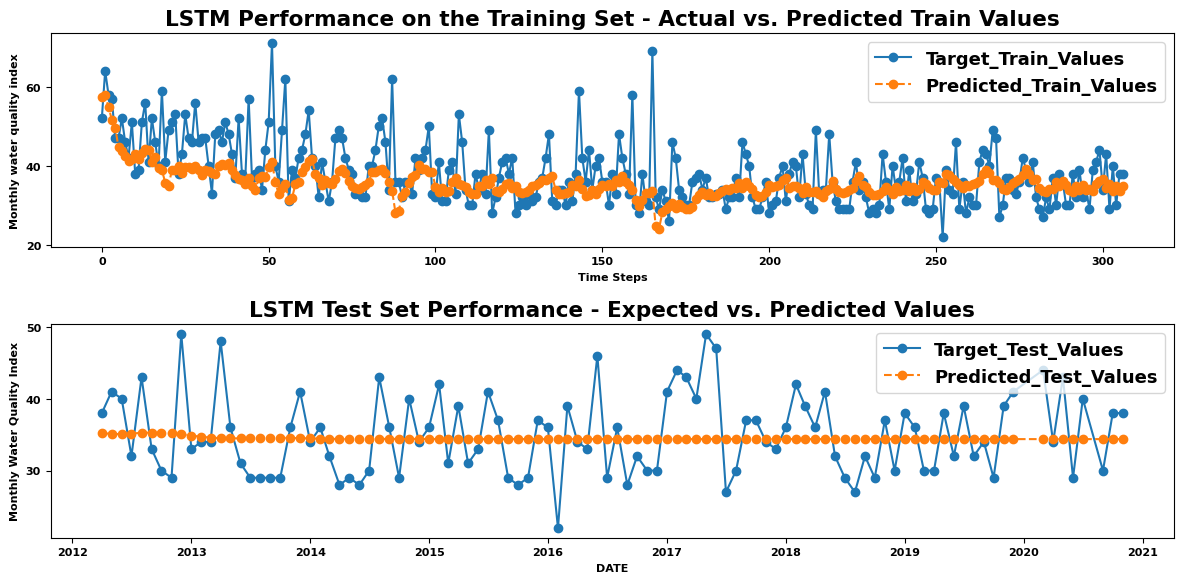

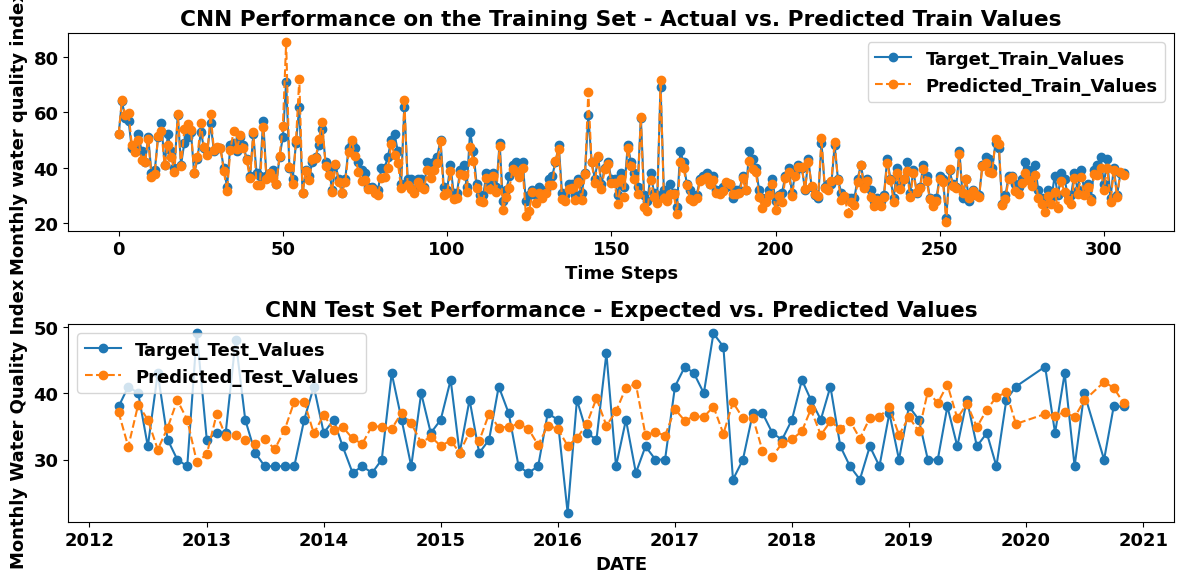

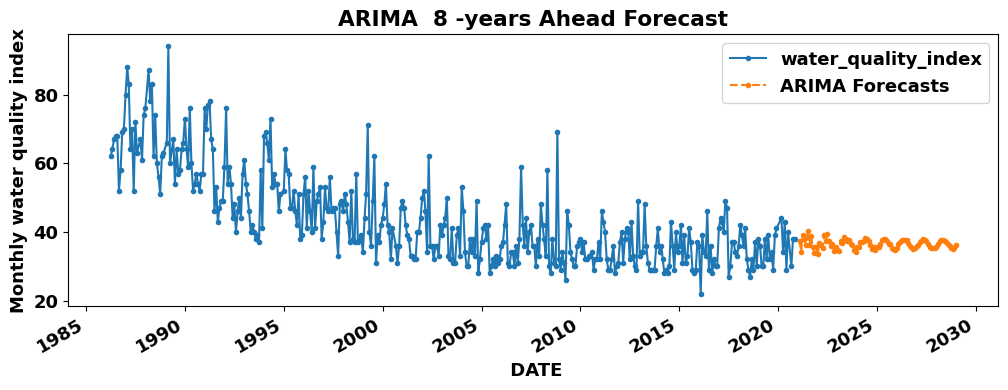

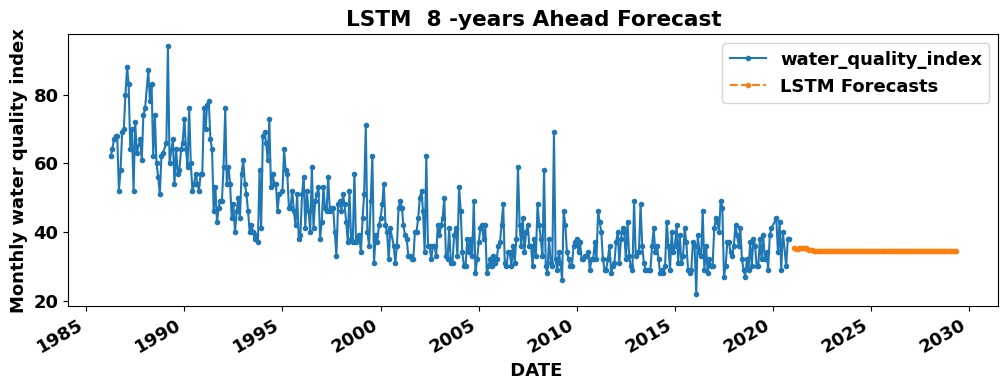

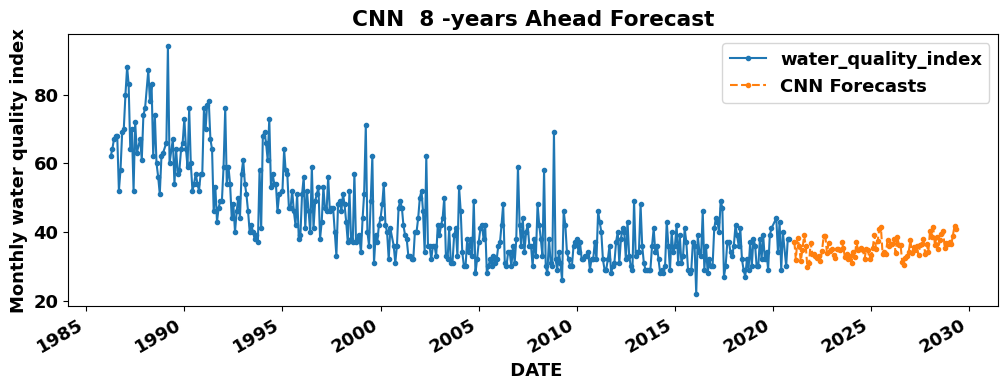

In [75]:
#model, choix_model = Choice_of_model ()
print("########################################## Test on the selected data ########################################### :" )
print(zone_river_station)

models = {'ARIMA', 'LSTM', 'CNN'}
two_models = {'LSTM', 'CNN'}
print('**************************************************TIME OF TRAINING*********************************************************************')
for choice in models :
  print("CPU time of "+ str(choice)+ " model : ", CPU_time[choice], "secondes")
print('**************************************************ERREUR*******************************************************************************')  
for choice in models :
  if(choice=='ARIMA'):
    print('Mean Square Erreur of ' + str(choice)+ ' model:',mean_squared_error(data,train_predictions[choice].to_frame().values))
  else :
    print('Mean Square Erreur of ' + str(choice)+ ' model:', mse[choice])

from pandas import DataFrame

for choice in models:
  #print(histories[choice].history.keys())
  if (choice=='ARIMA') :
   tracer_graph_for_error_for_arima(histories)
  else : 
    tracer_graph_for_error(choice,CPU_time,histories)

print('************************************************************************************************************************************')  
for choice in models:
  #print(histories[choice].history.keys())
  if(choice=='ARIMA'):
    tracer_graph_for_predict_all_dataset_with_cnn(data,length,test,train_predictions['ARIMA'].to_frame().values,'ARIMA')
  else:
    tracer_graph_for_predict_all_dataset_with_cnn(data,length,test,train_predictions[choice],choice)


('************************************************************************************************************************************')
for choice in two_models:
  #print(histories[choice].history.keys())
  tracer_graphe(test,train_predictions[choice],actual_train,choice)
('************************************************************************************************************************************')
for choice in models:
  #print(histories[choice].history.keys())
  if(choice=='ARIMA'):
    tracer_graph_for_forcasting_with_cnn(96,outputs_forcast[choice].to_frame().values,choice)
  else:
    tracer_graph_for_forcasting_with_cnn(length,outputs_forcast[choice],choice)